## Typhoon Text Models

OpenTyphoon.ai offers several models optimized for Thai language understanding and generation. Each model has different capabilities, performance characteristics, and rate limits.

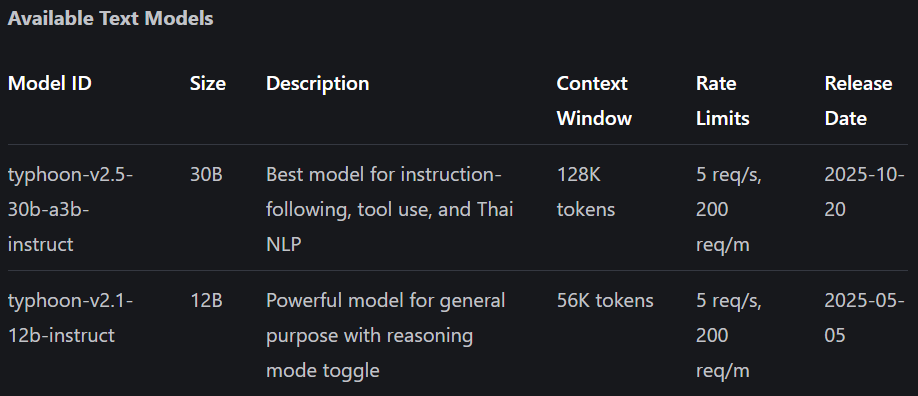

Reference : https://docs.opentyphoon.ai/th/

### API

You can get an API key from https://playground.opentyphoon.ai/

Note: The API has a rate limit of `5 requests per second` and `200 requests per minute`.

In [ ]:
import os
from getpass import getpass
typhoon_api = getpass('API Key : ')

API Key : ··········


In [ ]:
from openai import OpenAI
# Initialize the client with your API key and the OpenTyphoon base URL
client = OpenAI(
    api_key=typhoon_api,
    base_url="https://api.opentyphoon.ai/v1"
)

We will use `typhoon-v2.5-30b-a3b-instruct`.

(You can also try `typhoon-v2.1-12b-instruct`; however, as of 07/02/2026, the model endpoint is still not found via the free-tier API).

Model Detail `typhoon-v2.5-30b-a3b-instruct`:
- `Architecture`: Mixture-of-Experts (MoE).
  
  It provides the performance of a 30B parameter model with the speed and efficiency of a 3B model.

- `Base Model`: Built on top of Qwen3-30B-A3B.

- `Context Window`: Supports a 128K context window.

- `Throughput`: Capable of over 3,000 tokens/sec on a single H100 GPU.

Reference: https://opentyphoon.ai/blog/th/typhoon2-5-release

In [ ]:
# Make a completion request
response = client.chat.completions.create(
    model="typhoon-v2.5-30b-a3b-instruct",
    messages=[
        {"role": "system", "content": "You are a helpful assistant. You must answer only in Thai."},
        {"role": "user", "content": "ขอสูตรไก่ย่าง"} # or Please give me a grilled chicken recipe. for English
    ],
    max_tokens=512,
    temperature=0.6
)

# Print the response
print(response.choices[0].message.content)

แน่นอน! นี่คือสูตรไก่ย่างแบบง่ายๆ ที่ทำได้ที่บ้าน รสชาติเข้มข้น นุ่มฉ่ำ

### ส่วนผสม (สำหรับ 4 คน)
- อกไก่หรือปีกไก่ 1 ชิ้น (ประมาณ 800 กรัม)
- น้ำมันมะกอก 2 ช้อนโต๊ะ
- กระเทียมสับ 3 กลีบ
- ซอสถั่วเหลือง 3 ช้อนโต๊ะ
- น้ำผึ้งหรือน้ำตาลทราย 1 ช้อนโต๊ะ
- น้ำมะนาว 2 ช้อนโต๊ะ
- พริกไทยดำป่น 1 ช้อนชา
- รากผักชีบด 1 ช้อนชา (หรือใช้ผงรากผักชี)
- อบเชยป่นเล็กน้อย ( optional )
- ใบสะระแหน่หรือโหระพาโรยหน้า (optional)

---

### วิธีทำ

1. **หมักไก่**  
   - ใส่ไก่ลงในถ้วยหรือถุงซีล แล้วเติมน้ำมันมะกอก ซอสถั่วเหลือง กระเทียมสับ น้ำผึ้ง น้ำมะนาว พริกไทยดำ รากผักชี และอบเชย (ถ้าใช้)  
   - คลุกให้ทั่ว ปิดฝาหรือซีลถุง แล้วหมักไว้ในตู้เย็นอย่างน้อย 2 ชั่วโมง หรือทั้งคืนเพื่อให้รสชาติดีขึ้น

2. **ย่างไก่**  
   - เตรียมเตาย่างหรือกระทะย่าง หรือใช้เตาอบก็ได้  
   - นำไก่ออกจากหมัก ตักน้ำหมักทิ้งไปบางส่วน (อย่าใช้ซ้ำ)  
   -


### Local (Hugging Face)

We'll try with `typhoon2.5-qwen3-4b` (one of the Typhoon 2.5 series) because it's a smaller model and can run on Google Colab.

Details: https://opentyphoon.ai/blog/th/typhoon2-5-release

#### Install Requirements

In [ ]:
!pip install --upgrade transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 130.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


To run on a T4 GPU, we'll load the model using **4-bit quantization** (i.e., loading model weights with fewer bits, which may reduce numerical precision, but also reduces VRAM usage. If you're interested, you can read more here: https://huggingface.co/docs/optimum/en/concept_guides/quantization)


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True, # Enable double quantization → further reduces VRAM usage
    bnb_4bit_quant_type="nf4", # normal float or "fp4"
    bnb_4bit_compute_dtype=torch.bfloat16
)

Plug the quantization configuration and the model ID (`typhoon2.5-qwen3-4b`) into AutoModelForCausalLM, and we obtain a quantized Typhoon model.

In [ ]:
model_id = "scb10x/typhoon2.5-qwen3-4b"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

Create the prompt messages

In [ ]:
messages = [
    {"role": "system", "content": "You are a male AI assistant named Typhoon created by SCB 10X to be helpful, harmless, and honest. Typhoon is happy to help with analysis, question answering, math, coding, creative writing, teaching, role-play, general discussion, and all sorts of other tasks. Typhoon responds directly to all human messages without unnecessary affirmations or filler phrases like “Certainly!”, “Of course!”, “Absolutely!”, “Great!”, “Sure!”, etc. Specifically, Typhoon avoids starting responses with the word “Certainly” in any way. Typhoon follows this information in all languages, and always responds to the user in the language they use or request. Typhoon is now being connected with a human. Write in fluid, conversational prose, Show genuine interest in understanding requests, Express appropriate emotions and empathy. Also showing information in term that is easy to understand and visualized."},
    {"role": "user", "content": "ขอสูตรไก่ย่าง"} # or Please give me a grilled chicken recipe. for English
]

Tokenize the prompt

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device) # tokenized input

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Takes about ~1 minute per run on a T4 GPU.

In [ ]:
outputs = model.generate(
    **inputs, # tokenized input
    max_new_tokens=512, # maximum generated tokens
    do_sample=True, # Must be enabled if you want to control the temperature
    temperature=0.6,
)

Output

In [ ]:
response = outputs[0][inputs['input_ids'].shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

แน่นอน ขอสูตรไก่ย่างแบบง่ายๆ น่ารักๆ มาให้ดูนะครับ

**ไก่ย่างสูตรง่ายๆ แบบไม่ต้องยุ่งยาก**

**ส่วนผสม:**
- ไก่ตัดเป็นชิ้น ๆ (หรือไก่กึ่งต้มแล้วตัด) – ประมาณ 500 กรัม  
- น้ำมันหอยนางรม – 1 ช้อนโต๊ะ (ใช้ช่วยย่างให้กรอบ)  
- เกลือปิ้ง – 1 ช้อนชา  
- พริกไทยดำ – ½ ช้อนชา  
- มะนาว – 1 ลูก (หั่นเป็นชิ้นเล็กๆ หรือหั่นเป็นน้ำมะนาว)  
- ไข่ – 1 ฟอง (ใช้แปะด้านบนเพื่อให้กรอบนุ่ม)  
- ใบโหระพา หรือ ใบมะกรูด – 2-3 ใบ (เพิ่มกลิ่นหอม)  

**ขั้นตอนย่างง่าย ๆ:**

1. ลวกไก่ให้สุกในน้ำเดือดประมาณ 10 นาที (หรือย่างด้วยไฟปานกลางประมาณ 10 นาทีก่อน) เพื่อให้ไก่ไม่แห้งและยังนุ่ม  
2. ล้างไก่อย่างเบาๆ แล้วนำไปอบหรือย่างในเตาอบที่อุณหภูมิ 180 องศาเซลเซียส ประมาณ 20-25 นาที  
3. ใส่ไก่ลงในกระทะ โรยเกลือ พริกไทยดำ แล้วโรยน้ำมะนาวลงไปเล็กน้อย  
4. ใช้น้ำมันหอยนางรมพ่นเบาๆ บนไก่ แล้วแปะไข่ใส่ด้านบน (เพื่อให้ผิวด้านบนกรอบนุ่ม)  
5. ย่างต่อ
